In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data2_textonly.csv')

THEME = "CAREER"

filter_topics_includes = ["Growth and Development"]

print(len(df))
len(df.dropna(subset=['topics']))
df = df.dropna(subset=['topics'])
df = df[sum([df['topics'].str.contains(topic) for topic in filter_topics_includes])>=1]
vb = df['text']
vb = vb.dropna().reset_index()
print(len(df))
# vb = vb.iloc[0:500] # for faster performance, limit data in

55072
6234


In [2]:
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
import pyLDAvis.gensim_models

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain

c:\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Python310\lib\site-packages\joblib\backports.py:7: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


In [3]:
vb = vb.rename(columns={'Q46_Strengthen_EN':'text'}).drop(columns=['index'])
vb

text
0     For my Team, make use of S&D resources to find...
1     We think we do feedback well, but many people ...
2     Culture is driven from the top down. I have no...
3            Utilizing the Decide and Include training.
4                                   continuous feedback
...                                                 ...
6229  Status quo. It feels like we have only tried t...
6230  making people see that we all want to improve ...
6231  Working to make teams and people feel trusted,...
6232  I think we need to increase the appreciation o...
6233  I am actively working to make leadership and m...

[6234 rows x 1 columns]

In [4]:
# clean
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

vb['clean'] = vb.text.apply(lambda x: clean(x))
vb

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SB579KE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SB579KE\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


text  \
0     For my Team, make use of S&D resources to find...   
1     We think we do feedback well, but many people ...   
2     Culture is driven from the top down. I have no...   
3            Utilizing the Decide and Include training.   
4                                   continuous feedback   
...                                                 ...   
6229  Status quo. It feels like we have only tried t...   
6230  making people see that we all want to improve ...   
6231  Working to make teams and people feel trusted,...   
6232  I think we need to increase the appreciation o...   
6233  I am actively working to make leadership and m...   

                                                  clean  
0     [team, make, use, sd, resource, find, out, box...  
1     [think, feedback, well, many, people, idea, as...  
2     [culture, driven, top, down, ability, authorit...  
3                [utilizing, decide, include, training]  
4                                [continuous, feedback]  
...                                                 ...  
6229  [status, quo, feel, like, tried, maintain, sta...  
6230  [making, people, see, want, improve, worked, h...  
6231  [working, make, team, people, feel, trusted, e...  
6232  [think, need, increase, appreciation, technica...  
6233  [actively, working, make, leadership, manageme...  

[6234 rows x 2 columns]

In [5]:
dictionary = corpora.Dictionary(vb.clean)
print('Unique Words:', dictionary.num_nnz)

Unique Words: 138798


In [6]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in vb.clean]
print(len(doc_term_matrix))

6234


In [7]:
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)

In [8]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [9]:
lda_corpus = ldamodel[doc_term_matrix]

In [10]:
x = [doc for doc in lda_corpus]
x[3]

[(0, 0.052690703), (1, 0.83764064), (2, 0.05251141), (3, 0.05715729)]

In [11]:
scores = list(chain(*[[score for topic_id, score in topic] for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores) / len(scores)
print(threshold)

0.25000000002435124


In [12]:
cluster1 = [j for i,j in zip(lda_corpus,vb.index) if i[0][1] > threshold]
x = [doc for doc in lda_corpus]
prefix = 'cluster_fit_'
c_scores = [doc for doc in lda_corpus]

cluster_fit_cols = []

for i in range(len(lda_corpus[0])):
    cluster_id = i + 1
    new_cluster_fit_col = f"{prefix}{str(cluster_id)}"
    cluster_fit_cols.append(new_cluster_fit_col)
    vb[new_cluster_fit_col] = [c_scores[j][i][1] for j in range(len(lda_corpus))]


vb.to_csv('lda_cluster_results.csv')

In [13]:
number_top_comments_per_cluster = 20
max_comments = {}

for cluster_fit_col in cluster_fit_cols:
    max_fit_vb = vb.sort_values(cluster_fit_col,ascending=False).iloc[0:5]
    max_comments[cluster_fit_col] = max_fit_vb.text.tolist()

In [14]:
import json
filename = "lda_cluster_results_with_top"
json_path = f"{filename}.json"
csv_path = f"{filename}.csv"
with open(json_path,'w') as file:
    json.dump(max_comments, file)
pd.read_json(json_path).to_csv(csv_path)

In [15]:
# from wordcloud import WordCloud

# word_cloud = WordCloud(collocations=False, background_color='white').generate(" ".join(vb.text.tolist()))
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

result_best_fit_clusters = []

for index, row in vb.iterrows():
    best_fit_cluster = [cluster_col_name for cluster_col_name in cluster_fit_cols if row[cluster_col_name]>threshold][0]
    result_best_fit_clusters.append(best_fit_cluster)

best_fit_cluster_name = f'{THEME}_best_fit_cluster'

vb[best_fit_cluster_name] = result_best_fit_clusters

cluster_fit_1


cluster_fit_2


cluster_fit_3


cluster_fit_4


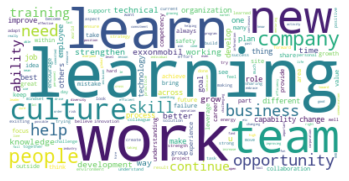

In [16]:
from wordcloud import WordCloud

cluster_fit_names = vb[f'{THEME}_best_fit_cluster'].unique().tolist()

excel_output_name = f"{THEME}_by_subtopic.xlsx"

with pd.ExcelWriter(excel_output_name) as xlsx_writer:
    for cluster_fit_name in sorted(cluster_fit_names):
        print(cluster_fit_name)
        # clean up the clean text for word cloud
        vb_current_cluster = vb[vb[best_fit_cluster_name]==cluster_fit_name]
        vb_current_cluster['clean_joined_text'] = [' '.join(clean_text_list) for clean_text_list in vb_current_cluster.clean.tolist()]

        # write to excel sheet
        sheet_name = f"{cluster_fit_name}"
        vb_current_cluster.to_excel(xlsx_writer, sheet_name=sheet_name, index=False)

        # generate word cloud
        word_cloud = WordCloud(collocations=False, background_color='white').generate(' '.join(vb_current_cluster.clean_joined_text.tolist()))
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis('off')
        plt.savefig(f"wordcloud_{THEME}_{cluster_fit_name}.png")
        plt.show()

# Subtopic Analysis

## Cluster 1: Performance Assessment
### Word Cloud
![](wordcloud_CAREER_cluster_fit_1.png)
### Key Verbatims

* The recent stand on no flying our Identity & Culture (ERG) flags at our facilities is another example of the disconnect and lack of leadership of our senior leaders, once again from VPs up. Our Performance Assessment (PA) is antiquated, demotivates and demoralizes our personnel. Do we really need to punish the BEST people? We spent months recruiting, interviewing, offering employment to the best only to run them out with PA. If the system is to recognize good behaviors, why is there a mandate of % for every bucket? Why do we have a mandated % for NSI? Can we not recognize that we have the BEST in the market? WE NEED A CHANGE OF SENIOR LEADERSHIP, VPs and all above. WE MUST BE MORE INCLUSIVE AND DIVERSE and accept differentiation =uniqueness
* Competition between individuals within the company, the relative performance assessment performance with fixed ratio in each category is not supporting our culture change objective. We need to reward performance but not put or force employees in assessment categories. this is destructive!!!
* I'm not changing anything but praying that the performance assessment will get out of the way. This is a good place to work , removing the performance assessment might make it a great place to work.

## Cluster 2: Openness, Honesty, and Togetherness
### Word Cloud
![](wordcloud_CAREER_cluster_fit_2.png)
### Key Verbatims

* I work in a culturally diverse team where some of the team may not feel comfortable speaking up in a group setting. I am committed to providing opportunities for those individuals to share their viewpoints, even if this means making time for one-on-one communication and then rerouting feedback to the wider group.
* Open honest communication and soliciting feedback from teammates and reports. Acting positively on feedback from the team to promote an environment that promotes inclusivity and a sense of value to the team.
* Promoting togetherness - working together, hands-on together, learn automation together with the whole team to promote team development rather than individual development/growth.
* Challenge the paradigms, focus on the development of our ways of working, improve and promote creativity

## Cluster 3: Career and Culture
### Word Cloud
![](wordcloud_CAREER_cluster_fit_3.png)
### Key Verbatims

* I am focusing on the area that I have the ability to influence - that being my immediate team. We continue to focus on creating an environment where there is psychological safety in putting forth ideas without fear of being reprimanded or belittled. I feel like we've been fairly successful, but as the employees in our team continue to go years without any significant pay increases, promotions, or new and exciting roles, it feels like we are at a point where some may begin to walk. I also worry that when they move to new roles, they will go to one of many teams that I am familiar with that do not have good psychological safety, don't allow the intended flexibility or have contentious atmospheres.
* I think we collectively need to empower our people to ensure we all feel appreciated, inspired and motivated and each of us are contributing to the Company's goals and vision. Given the number of voluntary resignations we have had in the last couple of years (some of which I still regret), it is undoubtedly clear that we need to step up our game as a Company and value our people's careers and bring back that sense of "job security" that most of us probably felt we had up until two years ago. I truly believe that OUR PEOPLE is ExxonMobil's most important asset, so let's do what we can to retain our people!
* I would like ExxonMobil to care more about IT people as you can see from number of people who left and are leaving the company but I have no idea on how it can be changed. We lost a huge number of good people. Many companies are heading to retain good IT people to still stay with the company whereas ExxonMobil has no clear technical career path and non competitive salary compared to the market and also aims to go with MSP option which cannot delivery works with good quality.
* How can we make people feel more valued at work and want to work for ExxonMobil over a long term career? We have lost a lot of good people over the last couple of years and several colleagues I have talked to have highlighted not "feeling valued" by the company as the primary reason for their departure. This is a change we must make!
* I'm in the company for only two months but, for what can I hear, one aspect that can be strengthened is the retention of our talents. I really don't know why is this for, as, personally, I feel very comfortable working here since I arrived.

## Cluster 4: Learning and Development
### Word Cloud
![](wordcloud_CAREER_cluster_fit_4.png)
### Key Verbatims

* I will only put people in roles who have experience and can help. I am not putting people in roles to "tick the Box". This is hurting our business and I am tired of the non value spin that I witness in meetings constantly. We need to get closer to the wellhead and manage our business better that way. Spending to much time on pie in the sky programs that are cool and hip but not very effective. I will spend my time mentoring and training my people side by side so they have the skills, confidence and knowledge to become competent rather then just hire a contractor. That has become our fall back method which hurts us when times are tough and we become reliant on contractors and they actually dictate our success.
* Leverage personal skills to help achieve or accomplish tasks in my division at ExxonMobil without relying on outside third parties, working on our own assets and being equipped with the right tools to complete the task will help strengthen and save the company money at ExxonMobil.
* Not everything we do is a success and we should learn to recognize that. Failure is healthy as you learn from it. If you admit failure early, you can save a lot of time and money . If we continue to pretend everything is a success, we loose credibility which is not a place you want to be in.
* Growth Mindset - continually learning and growing as an individual and using these learnings to help develop and grow the bigger team. Admitting mistakes and highlight what we have learned from these challenges.